In [1]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Generation

In [2]:
def generate_isotropic_gmm_data(d, N, scale_factor=1.0):
    M = int(np.log2(d))
    R = 2 * np.abs(np.log2(d))
    means = np.random.uniform(-R, R, size=(M, d))
    covariances = np.eye(d) * scale_factor
    weights = np.ones(M) / M
    
    # generate our data points
    data = []
    for _ in range(N):
        # choose the mixture component
        mixture_idx = np.random.choice(M, p=weights)
        mean = means[mixture_idx]
        data.append(np.random.multivariate_normal(mean, covariances)) #d et pas 1/d? 
    
    return np.array(data), means

d = 8
n_comp = int(np.log2(d))
N = 2**d
scale_factor = 1.0
synthetic_data, true_means = generate_isotropic_gmm_data(d, N, scale_factor)
print("Synthetic dataset shape:", synthetic_data.shape)

Synthetic dataset shape: (256, 8)


In [3]:
R = 2 * np.abs(np.log2(d))
means = np.random.uniform(-R, R, size=(3, 8))

In [4]:
means.shape

(3, 8)

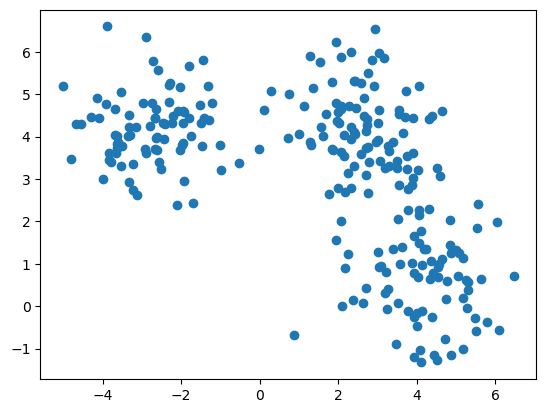

In [5]:
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1])

In [6]:
synthetic_data[:,0]

array([ 4.85894115,  5.63143161,  2.73435175,  4.08531828, -3.62722975,
        4.2516135 ,  6.10392122,  1.35856624,  4.76808034, -3.52297045,
        2.75880773, -2.23454188,  2.94780145, -2.51159751, -4.15371122,
        2.70456664,  2.26261964,  3.23449436, -3.69792604, -3.35008099,
        2.33785586, -1.32493035,  2.07680832,  3.55397005,  3.91727614,
        3.53125624,  2.14167163,  5.26764046, -1.42899501,  3.01670714,
        4.00708526, -2.11608187,  2.08322536,  4.73323112,  1.9415311 ,
       -2.75506293,  5.00820955, -3.84387757,  4.01065566,  4.59841954,
        2.90202841,  2.16604608,  0.71336187,  1.96092901,  2.43437147,
       -2.675792  ,  2.63934234,  0.73734865,  5.50045074, -2.65457382,
       -4.55956032, -1.94106676,  2.09187771, -3.67035789, -2.311441  ,
        4.05562135,  4.43961952, -2.09441075,  2.9671126 , -3.15970463,
        3.29658933,  3.79234431, -1.28118331,  4.50836411,  2.17821477,
        2.70671185, -3.89557722,  3.23050457,  3.40044071,  3.20

## EM algorithm

### Expectation-Maximization Algorithm for Gaussian Mixture Models

The Expectation-Maximization (EM) algorithm is an iterative method for finding the maximum likelihood estimates of parameters in statistical models, particularly useful for unsupervised learning tasks like clustering. In the context of Gaussian Mixture Models (GMM), the EM algorithm iteratively optimizes the parameters of multiple Gaussian distributions to fit the observed data.

#### Algorithm Steps:

1. **Initialization**: Start by initializing the parameters of the Gaussian components: means, covariances, and mixing coefficients.

2. **Expectation Step (E-step)**:
   - Compute the responsibilities (likelihoods) of each data point belonging to each Gaussian component.
   - Responsibilities are computed based on the current parameters using the multivariate normal distribution.

3. **Maximization Step (M-step)**:
   - Update the parameters (means, covariances, and mixing coefficients) using the responsibilities computed in the E-step.
   - Expressions for updating parameters:
     - **Means**: Weighted average of data points using responsibilities.
     - **Covariances**: Weighted covariance matrix of data points using responsibilities.
     - **Mixing Coefficients**: Mean of responsibilities.

4. **Compute Log-Likelihood**:
   - Compute the log-likelihood of the data given the current parameters and responsibilities.
   - Log-likelihood serves as a measure of how well the model fits the data.

5. **Convergence Check**:
   - Iterate between the E-step and M-step until convergence, typically based on a convergence criterion such as changes in log-likelihood or parameter values.

#### Expressions for Updating Parameters:

- **Means**: 

$$ \mu_k = \frac{\sum_{i=1}^{N} \gamma(z_{ik}) \cdot x_i}{\sum_{i=1}^{N} \gamma(z_{ik})} $$

- **Covariances**:
  $$ \Sigma_k = \frac{\sum_{i=1}^{N} \gamma(z_{ik}) \cdot (x_i - \mu_k)(x_i - \mu_k)^T}{\sum_{i=1}^{N} \gamma(z_{ik})} $$

- **Mixing Coefficients**:
  $$ \pi_k = \frac{\sum_{i=1}^{N} \gamma(z_{ik})}{N} $$

Here, $ \gamma(z_{ik}) $ represents the responsibility of data point $ x_i $ belonging to Gaussian component $ k $.



In [7]:
import numpy as np
from scipy.stats import multivariate_normal

def initialize_parameters(data, num_components):
    num_data_points, num_features = data.shape
    # Initialize means randomly
    means = np.random.rand(num_components, num_features)
    # Initialize covariances as identity matrices
    covariances = [np.eye(num_features)] * num_components
    # Initialize mixing coefficients uniformly
    mixing_coefficients = np.ones(num_components) / num_components
    return means, covariances, mixing_coefficients

def expectation_step(data, means, covariances, mixing_coefficients):
    num_data_points = len(data)
    num_components = len(means)
    responsibilities = np.zeros((num_data_points, num_components))

    for i in range(num_data_points):
        for j in range(num_components):
            responsibilities[i, j] = mixing_coefficients[j] * multivariate_normal.pdf(data[i], means[j], covariances[j])

    # Normalize the responsibilities
    responsibilities /= responsibilities.sum(axis=1)[:, np.newaxis]

    return responsibilities

def maximization_step(data, responsibilities):
    num_data_points, num_components = responsibilities.shape
    num_features = data.shape[1]
    means = np.zeros((num_components, num_features))
    covariances = [np.zeros((num_features, num_features))] * num_components
    mixing_coefficients = np.zeros(num_components)

    for j in range(num_components):
        # Update means
        means[j] = np.sum(responsibilities[:, j][:, np.newaxis] * data, axis=0) / np.sum(responsibilities[:, j])

        # Update covariances
        diff = data - means[j]
        covariances[j] = np.dot((responsibilities[:, j][:, np.newaxis] * diff).T, diff) / np.sum(responsibilities[:, j])

        # Update mixing coefficients
        mixing_coefficients[j] = np.mean(responsibilities[:, j])

    return means, covariances, mixing_coefficients

def em_algorithm(data, num_components, max_iterations=100, tolerance=1e-60):
    means, covariances, mixing_coefficients = initialize_parameters(data, num_components)
    prev_log_likelihood = float('-inf')

    for iteration in range(max_iterations):
        responsibilities = expectation_step(data, means, covariances, mixing_coefficients)
        means, covariances, mixing_coefficients = maximization_step(data, responsibilities)

        # Compute log-likelihood
        log_likelihood = np.sum(np.log(np.sum(responsibilities, axis=1)))
        print(f"Likelihood difference: {log_likelihood - prev_log_likelihood}")

        # Check for convergence
        if abs(log_likelihood - prev_log_likelihood) < tolerance:
            break

        prev_log_likelihood = log_likelihood

    return means, covariances, mixing_coefficients

num_components = n_comp # Number of Gaussian components
means, covariances, mixing_coefficients = em_algorithm(synthetic_data, num_components)
print("Means:", means)
print("Covariances:", covariances)
print("Mixing Coefficients:", mixing_coefficients)

Likelihood difference: inf
Likelihood difference: 3.1086244689504383e-15
Likelihood difference: -3.3306690738754676e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: 4.440892098500626e-16
Likelihood difference: 2.220446049250313e-16
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -1.1102230246251565e-15
Likelihood difference: -5.551115123125783e-16
Likelihood difference: 1.1102230246251565e-15
Likelihood difference: 7.771561172376095e-16
Likelihood difference: -2.220446049250312e-16
Likelihood difference: -1.1102230246251565e-15
Likelihood difference: 7.771561172376096e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 4.440892098500626e-16
Likelihood difference: -1.1102230246251565e-16
Likelihood difference: -2.220446049250313e-16
Likelihood difference: -3.3306690738754696e-16
Likelihood difference: 5.551115123125783e-16
Likeli

In [8]:
print(means)
print(true_means)

[[ 2.82256216  3.72702775  1.56627636  1.50306266  5.48765872 -5.23341079
  -0.59475157 -1.02634069]
 [ 2.57583397  4.22895525  1.07145912  2.23256159  5.82193776 -4.86979733
  -0.16750762 -1.74798222]
 [ 0.5595525   2.45997631  4.19127277  3.27064658 -3.16272554  0.83913899
   0.85298938 -2.96854934]]
[[ 2.47342384  4.22573492  1.32463424  1.99032367  5.8114155  -4.82798366
  -0.14849662 -1.63759682]
 [ 4.11152271  0.60525725  2.437919    0.9205192  -2.22249932  4.83888045
  -0.60607309 -5.98031584]
 [-2.86423722  4.25689187  5.71374065  5.41505262 -3.99175402 -2.75489079
   2.07496891 -0.02623007]]


## MALA

In [9]:
import seaborn as sns
import autograd.numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import torch
# package which differentiates standard Python and Numpy code
from autograd import grad
# to get progress bars
from tqdm import tqdm

In [100]:
def accept_filter(log_ratio, x, x_init):

    log_u = torch.log(torch.rand_like(log_ratio))
    acc = log_u < log_ratio
    x[~acc] = x_init[~acc]

    return x, acc


def get_grad_U(U):
    """
    Function to get grad of input function via autodiff
   
    U: function with single tensor input
    """
    @torch.enable_grad()
    def grad_U(x):
        x = x.clone().detach().requires_grad_()
        return torch.autograd.grad(U(x).sum(), x)[0]
    return grad_U

def run_mala(target_U, grad_U, x_init, n_steps=1000, dt=0.005, beta_eff=1, with_tqdm=False,cvg=False,criterions=[0,0]):
    """
    target_U: function - target potential we will run the Langevin on (negative log prob)
    grad_U: function - grad of target_U
    x (tensor): init points for the chains to update (batch_dim, dim)
    dt : time step
    beta_eff: additional control to change temperature of target U
    cvg: bool - runs the code until convergence criterions are met. if false, uruns the code for n_steps 
    criterions: list - the two tolerances for the convergence criterions. The first one uses the empirical mean of the log_likelihood of the generated sample, the second one uses the empirical mean of the sample.
    """
    def step(target_U, grad_U, x_init, n_steps, dt, beta_eff):
        """
        One step of the mala algorithm. This function was created to avoid repeating the code twice.
        """
        
        x = x_init.clone()
        x = x_init - dt * grad_U(x_init)
        if dt > 0:
            x += dt * np.sqrt(2 / (dt * beta_eff)) * torch.randn_like(x_init)

        log_ratio = -target_U(x)
        log_ratio -= ((x_init - x + dt * grad_U(x)) ** 2 / (4 * dt)).sum()
        log_ratio += target_U(x_init)  # Reshape to match the shape of log_ratio
        log_ratio += ((x - x_init + dt * grad_U(x_init)) ** 2 / (4 * dt)).sum()
        log_ratio = beta_eff * log_ratio

        x, acc = accept_filter(log_ratio, x, x_init)

        accs.append(acc)
        xs.append(x.clone())
        x_init = x.clone().detach()
        
        return xs,x_init,acc
    
    xs = []
    accs = []

    range_ = tqdm.tqdm(range(n_steps)) if with_tqdm else range(n_steps)
    if not cvg:
        
        for t in range_:
            xs,x_init,acc = step(target_U, grad_U, x_init, n_steps, dt, beta_eff)
            
    
    else:
        t=1
        crit_1 = np.inf
        crit_2 = np.inf
        sum_logprob_mala = 0
        
        
        while crit_1>1e-6  or crit_2>1e-3:
            if not xs:
                t+=1
                xs,x_init,acc = step(target_U, grad_U, x_init, n_steps, dt, beta_eff)
            else:
                xs,x_init,acc = step(target_U, grad_U, x_init, n_steps, dt, beta_eff)
                x_temp = torch.stack(xs)
                sum_logprob_mala += U(xs[-1])
                crit_1 = abs(sum_logprob_mala/t - criterions[0])
                
                empirical_mean=(torch.sum(x_temp,dim=0)/t).T
                crit_2 = np.linalg.norm(empirical_mean - criterions[1])
                t+=1
                if t%100:
                    print(f"iteration n°{t}")
        print(f"end of the loop. Number of iterations: {t}")
                
    return torch.stack(xs), torch.stack(accs)

In [69]:
# function that returns a function that computes the negative log probability of a given dataset
def get_log_prob(data):
    N = data.shape[0]
    d = data.shape[1]
    R = 2 * np.abs(np.log2(d))

    def log_mu_prior(mu):
        M = mu.shape[1]
        return -(torch.norm(mu) - np.sqrt(M) * R) ** 2 * int(torch.norm(mu) > np.sqrt(M) * R)

    def log_prob(mu):
        # Compute squared distances between each data point and each mean
        squared_distances = torch.sum((data.unsqueeze(1) - mu.t().unsqueeze(0)) ** 2, dim=2)

        # Compute the log probabilities for each data point and each mixture component
        log_probs = -0.5 * squared_distances / (1000 * data.shape[1])

        # Sum over mixture components and take the log-sum-exp to compute the log probability
        max_log_probs, _ = torch.max(log_probs, dim=1, keepdim=True)
        log_prob_ = torch.log(torch.sum(torch.exp(log_probs - max_log_probs), dim=1)) + max_log_probs.squeeze()

        return -torch.sum(log_prob_)

    return log_prob

In [70]:
M = int(np.log2(d))
U = get_log_prob(torch.Tensor(synthetic_data))
grad_U = get_grad_U(U)

x_init = torch.Tensor(synthetic_data[:M, :].T)

In [72]:
n_steps=50_000 #arbitrarly large number
mean_estimates=[]
logprob_estimates=[]
for i in range(0,2):
    objective_estimation, objective_accs = run_mala(U, grad_U, x_init, n_steps, dt=0.005)
    empirical_mean=(torch.sum(objective_estimation,dim=0)/n_steps).T
    log_prob_mala=0
    
    for j in range(n_steps):
        log_prob_mala += U(objective_estimation[j])/n_steps
    
        mean_estimates.append(empirical_mean)
        logprob_estimates.append(log_prob_mala)

In [81]:
log_prob_mala=0
for j in range(n_steps):
        log_prob_mala += U(objective_estimation[j])/n_steps
    
        mean_estimates.append(empirical_mean)
        logprob_estimates.append(log_prob_mala)

In [82]:
crit1 = sum(logprob_estimates)/len(logprob_estimates)
crit2 = sum(mean_estimates)/len(mean_estimates)

In [101]:
xs, accs,c = run_mala(U, grad_U, x_init, dt=0.005,cvg=True,criterions=[crit1,crit2])

iteration n°3
iteration n°4
iteration n°5
iteration n°6
iteration n°7
iteration n°8
iteration n°9
iteration n°10
iteration n°11
iteration n°12
iteration n°13
iteration n°14
iteration n°15
iteration n°16
iteration n°17
iteration n°18
iteration n°19
iteration n°20
iteration n°21
iteration n°22
iteration n°23
iteration n°24
iteration n°25
iteration n°26
iteration n°27
iteration n°28
iteration n°29
iteration n°30
iteration n°31
iteration n°32
iteration n°33
iteration n°34
iteration n°35
iteration n°36
iteration n°37
iteration n°38
iteration n°39
iteration n°40
iteration n°41
iteration n°42
iteration n°43
iteration n°44
iteration n°45
iteration n°46
iteration n°47
iteration n°48
iteration n°49
iteration n°50
iteration n°51
iteration n°52
iteration n°53
iteration n°54
iteration n°55
iteration n°56
iteration n°57
iteration n°58
iteration n°59
iteration n°60
iteration n°61
iteration n°62
iteration n°63
iteration n°64
iteration n°65
iteration n°66
iteration n°67
iteration n°68
iteration n°69
it

iteration n°601
iteration n°602
iteration n°603
iteration n°604
iteration n°605
iteration n°606
iteration n°607
iteration n°608
iteration n°609
iteration n°610
iteration n°611
iteration n°612
iteration n°613
iteration n°614
iteration n°615
iteration n°616
iteration n°617
iteration n°618
iteration n°619
iteration n°620
iteration n°621
iteration n°622
iteration n°623
iteration n°624
iteration n°625
iteration n°626
iteration n°627
iteration n°628
iteration n°629
iteration n°630
iteration n°631
iteration n°632
iteration n°633
iteration n°634
iteration n°635
iteration n°636
iteration n°637
iteration n°638
iteration n°639
iteration n°640
iteration n°641
iteration n°642
iteration n°643
iteration n°644
iteration n°645
iteration n°646
iteration n°647
iteration n°648
iteration n°649
iteration n°650
iteration n°651
iteration n°652
iteration n°653
iteration n°654
iteration n°655
iteration n°656
iteration n°657
iteration n°658
iteration n°659
iteration n°660
iteration n°661
iteration n°662
iteratio

iteration n°1131
iteration n°1132
iteration n°1133
iteration n°1134
iteration n°1135
iteration n°1136
iteration n°1137
iteration n°1138
iteration n°1139
iteration n°1140
iteration n°1141
iteration n°1142
iteration n°1143
iteration n°1144
iteration n°1145
iteration n°1146
iteration n°1147
iteration n°1148
iteration n°1149
iteration n°1150
iteration n°1151
iteration n°1152
iteration n°1153
iteration n°1154
iteration n°1155
iteration n°1156
iteration n°1157
iteration n°1158
iteration n°1159
iteration n°1160
iteration n°1161
iteration n°1162
iteration n°1163
iteration n°1164
iteration n°1165
iteration n°1166
iteration n°1167
iteration n°1168
iteration n°1169
iteration n°1170
iteration n°1171
iteration n°1172
iteration n°1173
iteration n°1174
iteration n°1175
iteration n°1176
iteration n°1177
iteration n°1178
iteration n°1179
iteration n°1180
iteration n°1181
iteration n°1182
iteration n°1183
iteration n°1184
iteration n°1185
iteration n°1186
iteration n°1187
iteration n°1188
iteration n°11

iteration n°1638
iteration n°1639
iteration n°1640
iteration n°1641
iteration n°1642
iteration n°1643
iteration n°1644
iteration n°1645
iteration n°1646
iteration n°1647
iteration n°1648
iteration n°1649
iteration n°1650
iteration n°1651
iteration n°1652
iteration n°1653
iteration n°1654
iteration n°1655
iteration n°1656
iteration n°1657
iteration n°1658
iteration n°1659
iteration n°1660
iteration n°1661
iteration n°1662
iteration n°1663
iteration n°1664
iteration n°1665
iteration n°1666
iteration n°1667
iteration n°1668
iteration n°1669
iteration n°1670
iteration n°1671
iteration n°1672
iteration n°1673
iteration n°1674
iteration n°1675
iteration n°1676
iteration n°1677
iteration n°1678
iteration n°1679
iteration n°1680
iteration n°1681
iteration n°1682
iteration n°1683
iteration n°1684
iteration n°1685
iteration n°1686
iteration n°1687
iteration n°1688
iteration n°1689
iteration n°1690
iteration n°1691
iteration n°1692
iteration n°1693
iteration n°1694
iteration n°1695
iteration n°16

iteration n°2187
iteration n°2188
iteration n°2189
iteration n°2190
iteration n°2191
iteration n°2192
iteration n°2193
iteration n°2194
iteration n°2195
iteration n°2196
iteration n°2197
iteration n°2198
iteration n°2199
iteration n°2201
iteration n°2202
iteration n°2203
iteration n°2204
iteration n°2205
iteration n°2206
iteration n°2207
iteration n°2208
iteration n°2209
iteration n°2210
iteration n°2211
iteration n°2212
iteration n°2213
iteration n°2214
iteration n°2215
iteration n°2216
iteration n°2217
iteration n°2218
iteration n°2219
iteration n°2220
iteration n°2221
iteration n°2222
iteration n°2223
iteration n°2224
iteration n°2225
iteration n°2226
iteration n°2227
iteration n°2228
iteration n°2229
iteration n°2230
iteration n°2231
iteration n°2232
iteration n°2233
iteration n°2234
iteration n°2235
iteration n°2236
iteration n°2237
iteration n°2238
iteration n°2239
iteration n°2240
iteration n°2241
iteration n°2242
iteration n°2243
iteration n°2244
iteration n°2245
iteration n°22

iteration n°2701
iteration n°2702
iteration n°2703
iteration n°2704
iteration n°2705
iteration n°2706
iteration n°2707
iteration n°2708
iteration n°2709
iteration n°2710
iteration n°2711
iteration n°2712
iteration n°2713
iteration n°2714
iteration n°2715
iteration n°2716
iteration n°2717
iteration n°2718
iteration n°2719
iteration n°2720
iteration n°2721
iteration n°2722
iteration n°2723
iteration n°2724
iteration n°2725
iteration n°2726
iteration n°2727
iteration n°2728
iteration n°2729
iteration n°2730
iteration n°2731
iteration n°2732
iteration n°2733
iteration n°2734
iteration n°2735
iteration n°2736
iteration n°2737
iteration n°2738
iteration n°2739
iteration n°2740
iteration n°2741
iteration n°2742
iteration n°2743
iteration n°2744
iteration n°2745
iteration n°2746
iteration n°2747
iteration n°2748
iteration n°2749
iteration n°2750
iteration n°2751
iteration n°2752
iteration n°2753
iteration n°2754
iteration n°2755
iteration n°2756
iteration n°2757
iteration n°2758
iteration n°27

iteration n°3242
iteration n°3243
iteration n°3244
iteration n°3245
iteration n°3246
iteration n°3247
iteration n°3248
iteration n°3249
iteration n°3250
iteration n°3251
iteration n°3252
iteration n°3253
iteration n°3254
iteration n°3255
iteration n°3256
iteration n°3257
iteration n°3258
iteration n°3259
iteration n°3260
iteration n°3261
iteration n°3262
iteration n°3263
iteration n°3264
iteration n°3265
iteration n°3266
iteration n°3267
iteration n°3268
iteration n°3269
iteration n°3270
iteration n°3271
iteration n°3272
iteration n°3273
iteration n°3274
iteration n°3275
iteration n°3276
iteration n°3277
iteration n°3278
iteration n°3279
iteration n°3280
iteration n°3281
iteration n°3282
iteration n°3283
iteration n°3284
iteration n°3285
iteration n°3286
iteration n°3287
iteration n°3288
iteration n°3289
iteration n°3290
iteration n°3291
iteration n°3292
iteration n°3293
iteration n°3294
iteration n°3295
iteration n°3296
iteration n°3297
iteration n°3298
iteration n°3299
iteration n°33

iteration n°3758
iteration n°3759
iteration n°3760
iteration n°3761
iteration n°3762
iteration n°3763
iteration n°3764
iteration n°3765
iteration n°3766
iteration n°3767
iteration n°3768
iteration n°3769
iteration n°3770
iteration n°3771
iteration n°3772
iteration n°3773
iteration n°3774
iteration n°3775
iteration n°3776
iteration n°3777
iteration n°3778
iteration n°3779
iteration n°3780
iteration n°3781
iteration n°3782
iteration n°3783
iteration n°3784
iteration n°3785
iteration n°3786
iteration n°3787
iteration n°3788
iteration n°3789
iteration n°3790
iteration n°3791
iteration n°3792
iteration n°3793
iteration n°3794
iteration n°3795
iteration n°3796
iteration n°3797
iteration n°3798
iteration n°3799
iteration n°3801
iteration n°3802
iteration n°3803
iteration n°3804
iteration n°3805
iteration n°3806
iteration n°3807
iteration n°3808
iteration n°3809
iteration n°3810
iteration n°3811
iteration n°3812
iteration n°3813
iteration n°3814
iteration n°3815
iteration n°3816
iteration n°38

iteration n°4289
iteration n°4290
iteration n°4291
iteration n°4292
iteration n°4293
iteration n°4294
iteration n°4295
iteration n°4296
iteration n°4297
iteration n°4298
iteration n°4299
iteration n°4301
iteration n°4302
iteration n°4303
iteration n°4304
iteration n°4305
iteration n°4306
iteration n°4307
iteration n°4308
iteration n°4309
iteration n°4310
iteration n°4311
iteration n°4312
iteration n°4313
iteration n°4314
iteration n°4315
iteration n°4316
iteration n°4317
iteration n°4318
iteration n°4319
iteration n°4320
iteration n°4321
iteration n°4322
iteration n°4323
iteration n°4324
iteration n°4325
iteration n°4326
iteration n°4327
iteration n°4328
iteration n°4329
iteration n°4330
iteration n°4331
iteration n°4332
iteration n°4333
iteration n°4334
iteration n°4335
iteration n°4336
iteration n°4337
iteration n°4338
iteration n°4339
iteration n°4340
iteration n°4341
iteration n°4342
iteration n°4343
iteration n°4344
iteration n°4345
iteration n°4346
iteration n°4347
iteration n°43

iteration n°4807
iteration n°4808
iteration n°4809
iteration n°4810
iteration n°4811
iteration n°4812
iteration n°4813
iteration n°4814
iteration n°4815
iteration n°4816
iteration n°4817
iteration n°4818
iteration n°4819
iteration n°4820
iteration n°4821
iteration n°4822
iteration n°4823
iteration n°4824
iteration n°4825
iteration n°4826
iteration n°4827
iteration n°4828
iteration n°4829
iteration n°4830
iteration n°4831
iteration n°4832
iteration n°4833
iteration n°4834
iteration n°4835
iteration n°4836
iteration n°4837
iteration n°4838
iteration n°4839
iteration n°4840
iteration n°4841
iteration n°4842
iteration n°4843
iteration n°4844
iteration n°4845
iteration n°4846
iteration n°4847
iteration n°4848
iteration n°4849
iteration n°4850
iteration n°4851
iteration n°4852
iteration n°4853
iteration n°4854
iteration n°4855
iteration n°4856
iteration n°4857
iteration n°4858
iteration n°4859
iteration n°4860
iteration n°4861
iteration n°4862
iteration n°4863
iteration n°4864
iteration n°48

iteration n°5298
iteration n°5299
iteration n°5301
iteration n°5302
iteration n°5303
iteration n°5304
iteration n°5305
iteration n°5306
iteration n°5307
iteration n°5308
iteration n°5309
iteration n°5310
iteration n°5311
iteration n°5312
iteration n°5313
iteration n°5314
iteration n°5315
iteration n°5316
iteration n°5317
iteration n°5318
iteration n°5319
iteration n°5320
iteration n°5321
iteration n°5322
iteration n°5323
iteration n°5324
iteration n°5325
iteration n°5326
iteration n°5327
iteration n°5328
iteration n°5329
iteration n°5330
iteration n°5331
iteration n°5332
iteration n°5333
iteration n°5334
iteration n°5335
iteration n°5336
iteration n°5337
iteration n°5338
iteration n°5339
iteration n°5340
iteration n°5341
iteration n°5342
iteration n°5343
iteration n°5344
iteration n°5345
iteration n°5346
iteration n°5347
iteration n°5348
iteration n°5349
iteration n°5350
iteration n°5351
iteration n°5352
iteration n°5353
iteration n°5354
iteration n°5355
iteration n°5356
iteration n°53

iteration n°5787
iteration n°5788
iteration n°5789
iteration n°5790
iteration n°5791
iteration n°5792
iteration n°5793
iteration n°5794
iteration n°5795
iteration n°5796
iteration n°5797
iteration n°5798
iteration n°5799
iteration n°5801
iteration n°5802
iteration n°5803
iteration n°5804
iteration n°5805
iteration n°5806
iteration n°5807
iteration n°5808
iteration n°5809
iteration n°5810
iteration n°5811
iteration n°5812
iteration n°5813
iteration n°5814
iteration n°5815
iteration n°5816
iteration n°5817
iteration n°5818
iteration n°5819
iteration n°5820
iteration n°5821
iteration n°5822
iteration n°5823
iteration n°5824
iteration n°5825
iteration n°5826
iteration n°5827
iteration n°5828
iteration n°5829
iteration n°5830
iteration n°5831
iteration n°5832
iteration n°5833
iteration n°5834
iteration n°5835
iteration n°5836
iteration n°5837
iteration n°5838
iteration n°5839
iteration n°5840
iteration n°5841
iteration n°5842
iteration n°5843
iteration n°5844
iteration n°5845
iteration n°58

iteration n°6291
iteration n°6292
iteration n°6293
iteration n°6294
iteration n°6295
iteration n°6296
iteration n°6297
iteration n°6298
iteration n°6299
iteration n°6301
iteration n°6302
iteration n°6303
iteration n°6304
iteration n°6305
iteration n°6306
iteration n°6307
iteration n°6308
iteration n°6309
iteration n°6310
iteration n°6311
iteration n°6312
iteration n°6313
iteration n°6314
iteration n°6315
iteration n°6316
iteration n°6317
iteration n°6318
iteration n°6319
iteration n°6320
iteration n°6321
iteration n°6322
iteration n°6323
iteration n°6324
iteration n°6325
iteration n°6326
iteration n°6327
iteration n°6328
iteration n°6329
iteration n°6330
iteration n°6331
iteration n°6332
iteration n°6333
iteration n°6334
iteration n°6335
iteration n°6336
iteration n°6337
iteration n°6338
iteration n°6339
iteration n°6340
iteration n°6341
iteration n°6342
iteration n°6343
iteration n°6344
iteration n°6345
iteration n°6346
iteration n°6347
iteration n°6348
iteration n°6349
iteration n°63

iteration n°6818
iteration n°6819
iteration n°6820
iteration n°6821
iteration n°6822
iteration n°6823
iteration n°6824
iteration n°6825
iteration n°6826
iteration n°6827
iteration n°6828
iteration n°6829
iteration n°6830
iteration n°6831
iteration n°6832
iteration n°6833
iteration n°6834
iteration n°6835
iteration n°6836
iteration n°6837
iteration n°6838
iteration n°6839
iteration n°6840
iteration n°6841
iteration n°6842
iteration n°6843
iteration n°6844
iteration n°6845
iteration n°6846
iteration n°6847
iteration n°6848
iteration n°6849
iteration n°6850
iteration n°6851
iteration n°6852
iteration n°6853
iteration n°6854
iteration n°6855
iteration n°6856
iteration n°6857
iteration n°6858
iteration n°6859
iteration n°6860
iteration n°6861
iteration n°6862
iteration n°6863
iteration n°6864
iteration n°6865
iteration n°6866
iteration n°6867
iteration n°6868
iteration n°6869
iteration n°6870
iteration n°6871
iteration n°6872
iteration n°6873
iteration n°6874
iteration n°6875
iteration n°68

iteration n°7313
iteration n°7314
iteration n°7315
iteration n°7316
iteration n°7317
iteration n°7318
iteration n°7319
iteration n°7320
iteration n°7321
iteration n°7322
iteration n°7323
iteration n°7324
iteration n°7325
iteration n°7326
iteration n°7327
iteration n°7328
iteration n°7329
iteration n°7330
iteration n°7331
iteration n°7332
iteration n°7333
iteration n°7334
iteration n°7335
iteration n°7336
iteration n°7337
iteration n°7338
iteration n°7339
iteration n°7340
iteration n°7341
iteration n°7342
iteration n°7343
iteration n°7344
iteration n°7345
iteration n°7346
iteration n°7347
iteration n°7348
iteration n°7349
iteration n°7350
iteration n°7351
iteration n°7352
iteration n°7353
iteration n°7354
iteration n°7355
iteration n°7356
iteration n°7357
iteration n°7358
iteration n°7359
iteration n°7360
iteration n°7361
iteration n°7362
iteration n°7363
iteration n°7364
iteration n°7365
iteration n°7366
iteration n°7367
iteration n°7368
iteration n°7369
iteration n°7370
iteration n°73

iteration n°7801
iteration n°7802
iteration n°7803
iteration n°7804
iteration n°7805
iteration n°7806
iteration n°7807
iteration n°7808
iteration n°7809
iteration n°7810
iteration n°7811
iteration n°7812
iteration n°7813
iteration n°7814
iteration n°7815
iteration n°7816
iteration n°7817
iteration n°7818
iteration n°7819
iteration n°7820
iteration n°7821
iteration n°7822
iteration n°7823
iteration n°7824
iteration n°7825
iteration n°7826
iteration n°7827
iteration n°7828
iteration n°7829
iteration n°7830
iteration n°7831
iteration n°7832
iteration n°7833
iteration n°7834
iteration n°7835
iteration n°7836
iteration n°7837
iteration n°7838
iteration n°7839
iteration n°7840
iteration n°7841
iteration n°7842
iteration n°7843
iteration n°7844
iteration n°7845
iteration n°7846
iteration n°7847
iteration n°7848
iteration n°7849
iteration n°7850
iteration n°7851
iteration n°7852
iteration n°7853
iteration n°7854
iteration n°7855
iteration n°7856
iteration n°7857
iteration n°7858
iteration n°78

iteration n°8287
iteration n°8288
iteration n°8289
iteration n°8290
iteration n°8291
iteration n°8292
iteration n°8293
iteration n°8294
iteration n°8295
iteration n°8296
iteration n°8297
iteration n°8298
iteration n°8299
iteration n°8301
iteration n°8302
iteration n°8303
iteration n°8304
iteration n°8305
iteration n°8306
iteration n°8307
iteration n°8308
iteration n°8309
iteration n°8310
iteration n°8311
iteration n°8312
iteration n°8313
iteration n°8314
iteration n°8315
iteration n°8316
iteration n°8317
iteration n°8318
iteration n°8319
iteration n°8320
iteration n°8321
iteration n°8322
iteration n°8323
iteration n°8324
iteration n°8325
iteration n°8326
iteration n°8327
iteration n°8328
iteration n°8329
iteration n°8330
iteration n°8331
iteration n°8332
iteration n°8333
iteration n°8334
iteration n°8335
iteration n°8336
iteration n°8337
iteration n°8338
iteration n°8339
iteration n°8340
iteration n°8341
iteration n°8342
iteration n°8343
iteration n°8344
iteration n°8345
iteration n°83

iteration n°8792
iteration n°8793
iteration n°8794
iteration n°8795
iteration n°8796
iteration n°8797
iteration n°8798
iteration n°8799
iteration n°8801
iteration n°8802
iteration n°8803
iteration n°8804
iteration n°8805
iteration n°8806
iteration n°8807
iteration n°8808
iteration n°8809
iteration n°8810
iteration n°8811
iteration n°8812
iteration n°8813
iteration n°8814
iteration n°8815
iteration n°8816
iteration n°8817
iteration n°8818
iteration n°8819
iteration n°8820
iteration n°8821
iteration n°8822
iteration n°8823
iteration n°8824
iteration n°8825
iteration n°8826
iteration n°8827
iteration n°8828
iteration n°8829
iteration n°8830
iteration n°8831
iteration n°8832
iteration n°8833
iteration n°8834
iteration n°8835
iteration n°8836
iteration n°8837
iteration n°8838
iteration n°8839
iteration n°8840
iteration n°8841
iteration n°8842
iteration n°8843
iteration n°8844
iteration n°8845
iteration n°8846
iteration n°8847
iteration n°8848
iteration n°8849
iteration n°8850
iteration n°88

iteration n°9291
iteration n°9292
iteration n°9293
iteration n°9294
iteration n°9295
iteration n°9296
iteration n°9297
iteration n°9298
iteration n°9299
iteration n°9301
iteration n°9302
iteration n°9303
iteration n°9304
iteration n°9305
iteration n°9306
iteration n°9307
iteration n°9308
iteration n°9309
iteration n°9310
iteration n°9311
iteration n°9312
iteration n°9313
iteration n°9314
iteration n°9315
iteration n°9316
iteration n°9317
iteration n°9318
iteration n°9319
iteration n°9320
iteration n°9321
iteration n°9322
iteration n°9323
iteration n°9324
iteration n°9325
iteration n°9326
iteration n°9327
iteration n°9328
iteration n°9329
iteration n°9330
iteration n°9331
iteration n°9332
iteration n°9333
iteration n°9334
iteration n°9335
iteration n°9336
iteration n°9337
iteration n°9338
iteration n°9339
iteration n°9340
iteration n°9341
iteration n°9342
iteration n°9343
iteration n°9344
iteration n°9345
iteration n°9346
iteration n°9347
iteration n°9348
iteration n°9349
iteration n°93

iteration n°9808
iteration n°9809
iteration n°9810
iteration n°9811
iteration n°9812
iteration n°9813
iteration n°9814
iteration n°9815
iteration n°9816
iteration n°9817
iteration n°9818
iteration n°9819
iteration n°9820
iteration n°9821
iteration n°9822
iteration n°9823
iteration n°9824
iteration n°9825
iteration n°9826
iteration n°9827
iteration n°9828
iteration n°9829
iteration n°9830
iteration n°9831
iteration n°9832
iteration n°9833
iteration n°9834
iteration n°9835
iteration n°9836
iteration n°9837
iteration n°9838
iteration n°9839
iteration n°9840
iteration n°9841
iteration n°9842
iteration n°9843
iteration n°9844
iteration n°9845
iteration n°9846
iteration n°9847
iteration n°9848
iteration n°9849
iteration n°9850
iteration n°9851
iteration n°9852
iteration n°9853
iteration n°9854
iteration n°9855
iteration n°9856
iteration n°9857
iteration n°9858
iteration n°9859
iteration n°9860
iteration n°9861
iteration n°9862
iteration n°9863
iteration n°9864
iteration n°9865
iteration n°98

iteration n°10296
iteration n°10297
iteration n°10298
iteration n°10299
iteration n°10301
iteration n°10302
iteration n°10303
iteration n°10304
iteration n°10305
iteration n°10306
iteration n°10307
iteration n°10308
iteration n°10309
iteration n°10310
iteration n°10311
iteration n°10312
iteration n°10313
iteration n°10314
iteration n°10315
iteration n°10316
iteration n°10317
iteration n°10318
iteration n°10319
iteration n°10320
iteration n°10321
iteration n°10322
iteration n°10323
iteration n°10324
iteration n°10325
iteration n°10326
iteration n°10327
iteration n°10328
iteration n°10329
iteration n°10330
iteration n°10331
iteration n°10332
iteration n°10333
iteration n°10334
iteration n°10335
iteration n°10336
iteration n°10337
iteration n°10338
iteration n°10339
iteration n°10340
iteration n°10341
iteration n°10342
iteration n°10343
iteration n°10344
iteration n°10345
iteration n°10346
iteration n°10347
iteration n°10348
iteration n°10349
iteration n°10350
iteration n°10351
iteration 

iteration n°10771
iteration n°10772
iteration n°10773
iteration n°10774
iteration n°10775
iteration n°10776
iteration n°10777
iteration n°10778
iteration n°10779
iteration n°10780
iteration n°10781
iteration n°10782
iteration n°10783
iteration n°10784
iteration n°10785
iteration n°10786
iteration n°10787
iteration n°10788
iteration n°10789
iteration n°10790
iteration n°10791
iteration n°10792
iteration n°10793
iteration n°10794
iteration n°10795
iteration n°10796
iteration n°10797
iteration n°10798
iteration n°10799
iteration n°10801
iteration n°10802
iteration n°10803
iteration n°10804
iteration n°10805
iteration n°10806
iteration n°10807
iteration n°10808
iteration n°10809
iteration n°10810
iteration n°10811
iteration n°10812
iteration n°10813
iteration n°10814
iteration n°10815
iteration n°10816
iteration n°10817
iteration n°10818
iteration n°10819
iteration n°10820
iteration n°10821
iteration n°10822
iteration n°10823
iteration n°10824
iteration n°10825
iteration n°10826
iteration 

iteration n°11248
iteration n°11249
iteration n°11250
iteration n°11251
iteration n°11252
iteration n°11253
iteration n°11254
iteration n°11255
iteration n°11256
iteration n°11257
iteration n°11258
iteration n°11259
iteration n°11260
iteration n°11261
iteration n°11262
iteration n°11263
iteration n°11264
iteration n°11265
iteration n°11266
iteration n°11267
iteration n°11268
iteration n°11269
iteration n°11270
iteration n°11271
iteration n°11272
iteration n°11273
iteration n°11274
iteration n°11275
iteration n°11276
iteration n°11277
iteration n°11278
iteration n°11279
iteration n°11280
iteration n°11281
iteration n°11282
iteration n°11283
iteration n°11284
iteration n°11285
iteration n°11286
iteration n°11287
iteration n°11288
iteration n°11289
iteration n°11290
iteration n°11291
iteration n°11292
iteration n°11293
iteration n°11294
iteration n°11295
iteration n°11296
iteration n°11297
iteration n°11298
iteration n°11299
iteration n°11301
iteration n°11302
iteration n°11303
iteration 

iteration n°11732
iteration n°11733
iteration n°11734
iteration n°11735
iteration n°11736
iteration n°11737
iteration n°11738
iteration n°11739
iteration n°11740
iteration n°11741
iteration n°11742
iteration n°11743
iteration n°11744
iteration n°11745
iteration n°11746
iteration n°11747
iteration n°11748
iteration n°11749
iteration n°11750
iteration n°11751
iteration n°11752
iteration n°11753
iteration n°11754
iteration n°11755
iteration n°11756
iteration n°11757
iteration n°11758
iteration n°11759
iteration n°11760
iteration n°11761
iteration n°11762
iteration n°11763
iteration n°11764
iteration n°11765
iteration n°11766
iteration n°11767
iteration n°11768
iteration n°11769
iteration n°11770
iteration n°11771
iteration n°11772
iteration n°11773
iteration n°11774
iteration n°11775
iteration n°11776
iteration n°11777
iteration n°11778
iteration n°11779
iteration n°11780
iteration n°11781
iteration n°11782
iteration n°11783
iteration n°11784
iteration n°11785
iteration n°11786
iteration 

iteration n°12218
iteration n°12219
iteration n°12220
iteration n°12221
iteration n°12222
iteration n°12223
iteration n°12224
iteration n°12225
iteration n°12226
iteration n°12227
iteration n°12228
iteration n°12229
iteration n°12230
iteration n°12231
iteration n°12232
iteration n°12233
iteration n°12234
iteration n°12235
iteration n°12236
iteration n°12237
iteration n°12238
iteration n°12239
iteration n°12240
iteration n°12241
iteration n°12242
iteration n°12243
iteration n°12244
iteration n°12245
iteration n°12246
iteration n°12247
iteration n°12248
iteration n°12249
iteration n°12250
iteration n°12251
iteration n°12252
iteration n°12253
iteration n°12254
iteration n°12255
iteration n°12256
iteration n°12257
iteration n°12258
iteration n°12259
iteration n°12260
iteration n°12261
iteration n°12262
iteration n°12263
iteration n°12264
iteration n°12265
iteration n°12266
iteration n°12267
iteration n°12268
iteration n°12269
iteration n°12270
iteration n°12271
iteration n°12272
iteration 

iteration n°12695
iteration n°12696
iteration n°12697
iteration n°12698
iteration n°12699
iteration n°12701
iteration n°12702
iteration n°12703
iteration n°12704
iteration n°12705
iteration n°12706
iteration n°12707
iteration n°12708
iteration n°12709
iteration n°12710
iteration n°12711
iteration n°12712
iteration n°12713
iteration n°12714
iteration n°12715
iteration n°12716
iteration n°12717
iteration n°12718
iteration n°12719
iteration n°12720
iteration n°12721
iteration n°12722
iteration n°12723
iteration n°12724
iteration n°12725
iteration n°12726
iteration n°12727
iteration n°12728
iteration n°12729
iteration n°12730
iteration n°12731
iteration n°12732
iteration n°12733
iteration n°12734
iteration n°12735
iteration n°12736
iteration n°12737
iteration n°12738
iteration n°12739
iteration n°12740
iteration n°12741
iteration n°12742
iteration n°12743
iteration n°12744
iteration n°12745
iteration n°12746
iteration n°12747
iteration n°12748
iteration n°12749
iteration n°12750
iteration 

iteration n°13176
iteration n°13177
iteration n°13178
iteration n°13179
iteration n°13180
iteration n°13181
iteration n°13182
iteration n°13183
iteration n°13184
iteration n°13185
iteration n°13186
iteration n°13187
iteration n°13188
iteration n°13189
iteration n°13190
iteration n°13191
iteration n°13192
iteration n°13193
iteration n°13194
iteration n°13195
iteration n°13196
iteration n°13197
iteration n°13198
iteration n°13199
iteration n°13201
iteration n°13202
iteration n°13203
iteration n°13204
iteration n°13205
iteration n°13206
iteration n°13207
iteration n°13208
iteration n°13209
iteration n°13210
iteration n°13211
iteration n°13212
iteration n°13213
iteration n°13214
iteration n°13215
iteration n°13216
iteration n°13217
iteration n°13218
iteration n°13219
iteration n°13220
iteration n°13221
iteration n°13222
iteration n°13223
iteration n°13224
iteration n°13225
iteration n°13226
iteration n°13227
iteration n°13228
iteration n°13229
iteration n°13230
iteration n°13231
iteration 

iteration n°13646
iteration n°13647
iteration n°13648
iteration n°13649
iteration n°13650
iteration n°13651
iteration n°13652
iteration n°13653
iteration n°13654
iteration n°13655
iteration n°13656
iteration n°13657
iteration n°13658
iteration n°13659
iteration n°13660
iteration n°13661
iteration n°13662
iteration n°13663
iteration n°13664
iteration n°13665
iteration n°13666
iteration n°13667
iteration n°13668
iteration n°13669
iteration n°13670
iteration n°13671
iteration n°13672
iteration n°13673
iteration n°13674
iteration n°13675
iteration n°13676
iteration n°13677
iteration n°13678
iteration n°13679
iteration n°13680
iteration n°13681
iteration n°13682
iteration n°13683
iteration n°13684
iteration n°13685
iteration n°13686
iteration n°13687
iteration n°13688
iteration n°13689
iteration n°13690
iteration n°13691
iteration n°13692
iteration n°13693
iteration n°13694
iteration n°13695
iteration n°13696
iteration n°13697
iteration n°13698
iteration n°13699
iteration n°13701
iteration 

iteration n°14107
iteration n°14108
iteration n°14109
iteration n°14110
iteration n°14111
iteration n°14112
iteration n°14113
iteration n°14114
iteration n°14115
iteration n°14116
iteration n°14117
iteration n°14118
iteration n°14119
iteration n°14120
iteration n°14121
iteration n°14122
iteration n°14123
iteration n°14124
iteration n°14125
iteration n°14126
iteration n°14127
iteration n°14128
iteration n°14129
iteration n°14130
iteration n°14131
iteration n°14132
iteration n°14133
iteration n°14134
iteration n°14135
iteration n°14136
iteration n°14137
iteration n°14138
iteration n°14139
iteration n°14140
iteration n°14141
iteration n°14142
iteration n°14143
iteration n°14144
iteration n°14145
iteration n°14146
iteration n°14147
iteration n°14148
iteration n°14149
iteration n°14150
iteration n°14151
iteration n°14152
iteration n°14153
iteration n°14154
iteration n°14155
iteration n°14156
iteration n°14157
iteration n°14158
iteration n°14159
iteration n°14160
iteration n°14161
iteration 

iteration n°14581
iteration n°14582
iteration n°14583
iteration n°14584
iteration n°14585
iteration n°14586
iteration n°14587
iteration n°14588
iteration n°14589
iteration n°14590
iteration n°14591
iteration n°14592
iteration n°14593
iteration n°14594
iteration n°14595
iteration n°14596
iteration n°14597
iteration n°14598
iteration n°14599
iteration n°14601
iteration n°14602
iteration n°14603
iteration n°14604
iteration n°14605
iteration n°14606
iteration n°14607
iteration n°14608
iteration n°14609
iteration n°14610
iteration n°14611
iteration n°14612
iteration n°14613
iteration n°14614
iteration n°14615
iteration n°14616
iteration n°14617
iteration n°14618
iteration n°14619
iteration n°14620
iteration n°14621
iteration n°14622
iteration n°14623
iteration n°14624
iteration n°14625
iteration n°14626
iteration n°14627
iteration n°14628
iteration n°14629
iteration n°14630
iteration n°14631
iteration n°14632
iteration n°14633
iteration n°14634
iteration n°14635
iteration n°14636
iteration 

iteration n°15051
iteration n°15052
iteration n°15053
iteration n°15054
iteration n°15055
iteration n°15056
iteration n°15057
iteration n°15058
iteration n°15059
iteration n°15060
iteration n°15061
iteration n°15062
iteration n°15063
iteration n°15064
iteration n°15065
iteration n°15066
iteration n°15067
iteration n°15068
iteration n°15069
iteration n°15070
iteration n°15071
iteration n°15072
iteration n°15073
iteration n°15074
iteration n°15075
iteration n°15076
iteration n°15077
iteration n°15078
iteration n°15079
iteration n°15080
iteration n°15081
iteration n°15082
iteration n°15083
iteration n°15084
iteration n°15085
iteration n°15086
iteration n°15087
iteration n°15088
iteration n°15089
iteration n°15090
iteration n°15091
iteration n°15092
iteration n°15093
iteration n°15094
iteration n°15095
iteration n°15096
iteration n°15097
iteration n°15098
iteration n°15099
iteration n°15101
iteration n°15102
iteration n°15103
iteration n°15104
iteration n°15105
iteration n°15106
iteration 

iteration n°15521
iteration n°15522
iteration n°15523
iteration n°15524
iteration n°15525
iteration n°15526
iteration n°15527
iteration n°15528
iteration n°15529
iteration n°15530
iteration n°15531
iteration n°15532
iteration n°15533
iteration n°15534
iteration n°15535
iteration n°15536
iteration n°15537
iteration n°15538
iteration n°15539
iteration n°15540
iteration n°15541
iteration n°15542
iteration n°15543
iteration n°15544
iteration n°15545
iteration n°15546
iteration n°15547
iteration n°15548
iteration n°15549
iteration n°15550
iteration n°15551
iteration n°15552
iteration n°15553
iteration n°15554
iteration n°15555
iteration n°15556
iteration n°15557
iteration n°15558
iteration n°15559
iteration n°15560
iteration n°15561
iteration n°15562
iteration n°15563
iteration n°15564
iteration n°15565
iteration n°15566
iteration n°15567
iteration n°15568
iteration n°15569
iteration n°15570
iteration n°15571
iteration n°15572
iteration n°15573
iteration n°15574
iteration n°15575
iteration 

iteration n°15987
iteration n°15988
iteration n°15989
iteration n°15990
iteration n°15991
iteration n°15992
iteration n°15993
iteration n°15994
iteration n°15995
iteration n°15996
iteration n°15997
iteration n°15998
iteration n°15999
iteration n°16001
iteration n°16002
iteration n°16003
iteration n°16004
iteration n°16005
iteration n°16006
iteration n°16007
iteration n°16008
iteration n°16009
iteration n°16010
iteration n°16011
iteration n°16012
iteration n°16013
iteration n°16014
iteration n°16015
iteration n°16016
iteration n°16017
iteration n°16018
iteration n°16019
iteration n°16020
iteration n°16021
iteration n°16022
iteration n°16023
iteration n°16024
iteration n°16025
iteration n°16026
iteration n°16027
iteration n°16028
iteration n°16029
iteration n°16030
iteration n°16031
iteration n°16032
iteration n°16033
iteration n°16034
iteration n°16035
iteration n°16036
iteration n°16037
iteration n°16038
iteration n°16039
iteration n°16040
iteration n°16041
iteration n°16042
iteration 

iteration n°16458
iteration n°16459
iteration n°16460
iteration n°16461
iteration n°16462
iteration n°16463
iteration n°16464
iteration n°16465
iteration n°16466
iteration n°16467
iteration n°16468
iteration n°16469
iteration n°16470
iteration n°16471
iteration n°16472
iteration n°16473
iteration n°16474
iteration n°16475
iteration n°16476
iteration n°16477
iteration n°16478
iteration n°16479
iteration n°16480
iteration n°16481
iteration n°16482
iteration n°16483
iteration n°16484
iteration n°16485
iteration n°16486
iteration n°16487
iteration n°16488
iteration n°16489
iteration n°16490
iteration n°16491
iteration n°16492
iteration n°16493
iteration n°16494
iteration n°16495
iteration n°16496
iteration n°16497
iteration n°16498
iteration n°16499
iteration n°16501
iteration n°16502
iteration n°16503
iteration n°16504
iteration n°16505
iteration n°16506
iteration n°16507
iteration n°16508
iteration n°16509
iteration n°16510
iteration n°16511
iteration n°16512
iteration n°16513
iteration 

KeyboardInterrupt: 